# Cross-modality cell matching

In [1]:
# Import packages
import os
import pandas as pd
import numpy as np
import scanpy as sc
import scipy
import ot
import umap
import scib

In [2]:
# Load data
rna = np.load("rna_cell_embs.npy")
atac = np.load("atac_cell_embs.npy")
cell = np.load("cell_names.npy")
label = pd.read_csv("labels.tsv.gz", sep = ",", header = None, names = ["barcode", "cell_type"])
print(f"RNA: {rna.shape}; ATAC: {atac.shape}")

RNA: (9631, 512); ATAC: (9631, 512)


In [3]:
# Calculate distance
M = scipy.spatial.distance.cdist(rna, atac, metric = "cosine")
a = np.ones(rna.shape[0]) / rna.shape[0]
b = np.ones(atac.shape[0]) / atac.shape[0]
d = ot.sinkhorn(a, b, M, reg = 1e-4, numItermax = 10000)
d = pd.DataFrame(-d, index = pd.Series(cell, name = "GEX"), columns = pd.Series(cell, name = "ATAC"))

In [4]:
# Evaluate matching accuracy
match_accuracy_x = ((d < np.diag(d)[:, None]).sum(axis = 1) < 1) & (d.max(axis = 1) != np.diag(d))
match_accuracy_y = ((d < np.diag(d)[None, :]).sum(axis = 0) < 1) & (d.max(axis = 0) != np.diag(d))
print(f"GEX->ATAC: {match_accuracy_x.mean()}")
print(f"ATAC->GEX: {match_accuracy_y.mean()}")
print(f"Overall: {(match_accuracy_x.mean() + match_accuracy_y.mean()) / 2}")

GEX->ATAC: 0.0912677811234555
ATAC->GEX: 0.09116394974561312
Overall: 0.0912158654345343


In [5]:
# Evaluate foscttm
foscttm_x = ((d < np.diag(d)[:, None]) | ((d.max(axis = 1) == np.diag(d)).values[:, None])).mean(axis = 1)
foscttm_y = ((d < np.diag(d)[None, :]) | ((d.max(axis = 0) == np.diag(d)).values[None, :])).mean(axis = 0)
print(f"GEX->ATAC: {foscttm_x.mean()}")
print(f"ATAC->GEX: {foscttm_y.mean()}")
print(f"Overall: {(foscttm_x.mean() + foscttm_y.mean()) / 2}")

GEX->ATAC: 0.01083760894330243
ATAC->GEX: 0.010864830854739665
Overall: 0.010851219899021047


In [6]:
# Evaluate top matching
for ntop in [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 40, 50]:
    top_match_x = ((d < np.diag(d)[:, None]).sum(axis = 1) < ntop) & (d.max(axis = 1) != np.diag(d))
    top_match_y = ((d < np.diag(d)[None, :]).sum(axis = 0) < ntop) & (d.max(axis = 0) != np.diag(d))
    print(f"Top-{ntop} GEX->ATAC: {top_match_x.mean()}")
    print(f"Top-{ntop} ATAC->GEX: {top_match_y.mean()}")
    print(f"Top-{ntop} Overall: {(top_match_x.mean() + top_match_y.mean()) / 2}")

Top-10 GEX->ATAC: 0.31242861592773336
Top-10 ATAC->GEX: 0.3148167376181082
Top-10 Overall: 0.31362267677292077
Top-50 GEX->ATAC: 0.5895545633890562
Top-50 ATAC->GEX: 0.5929809988578548
Top-50 Overall: 0.5912677811234555


In [7]:
# Evaluate cell type matching
c2t = {row["barcode"]: row["cell_type"] for _, row in label.iterrows()}
t2c = {c: m["barcode"].tolist() for c, m in label.groupby("cell_type")}
dx = [d.loc[c, t2c[c2t[c]]].min() for c in d.index]
dy = [d.loc[t2c[c2t[c]], c].min() for c in d.columns]
dx = pd.Series(dx, index = d.index)
dy = pd.Series(dy, index = d.columns)
cell_type_match_x = ((d < dx.values[:, None]).sum(axis = 1) < 1) & (d.max(axis = 1) != dx)
cell_type_match_y = ((d < dy.values[None, :]).sum(axis = 0) < 1) & (d.max(axis = 0) != dy)
df = pd.DataFrame({"cell_type": label["cell_type"].values,
                   "score": np.stack([cell_type_match_x, cell_type_match_y]).mean(axis = 0)})
print(df.groupby("cell_type").agg(score = ("score", "mean")).reset_index())

         cell_type     score
0        CD14 Mono  0.982381
1        CD16 Mono  0.919683
2        CD4 Naive  0.905933
3          CD4 TCM  0.849057
4          CD4 TEM  0.756993
5        CD8 Naive  0.954210
6        CD8 TEM_1  0.832298
7        CD8 TEM_2  0.855556
8             HSPC  1.000000
9   Intermediate B  0.858333
10            MAIT  0.896154
11        Memory B  0.949664
12              NK  0.980149
13         Naive B  0.704000
14          Plasma  1.000000
15            Treg  0.770701
16             cDC  0.941667
17             gdT  0.688811
18             pDC  1.000000


In [8]:
# Dimension reduction
a = np.ones(rna.shape[0]) / rna.shape[0]
b = np.ones(atac.shape[0]) / atac.shape[0]
M0 = scipy.spatial.distance.cdist(rna, atac, metric = "cosine")
G0 = ot.sinkhorn(a, b, M0, reg = 1e-4, numItermax = 10000)
G0 = G0 / G0.max()
M1 = scipy.spatial.distance.cdist(rna, rna, metric = "cosine")
G1 = ot.sinkhorn(a, a, M1, reg = 1e-4, numItermax = 10000)
G1 = G1 / G1.max()
M2 = scipy.spatial.distance.cdist(atac, atac, metric = "cosine")
G2 = ot.sinkhorn(b, b, M2, reg = 1e-4, numItermax = 10000)
G2 = G2 / G2.max()
M3 = scipy.spatial.distance.cdist(atac, rna, metric = "cosine")
G3 = ot.sinkhorn(a, b, M3, reg = 1e-4, numItermax = 10000)
G3 = G3 / G3.max()

In [9]:
distance = np.block([[1 - G1, 1 - G0], [1 - G3, 1 - G2]])
latent_300 = umap.UMAP(n_components = 300, metric = "precomputed", min_dist = 0.5).fit_transform(distance)
latent_2 = umap.UMAP(n_components = 2, metric = "precomputed", min_dist = 0.5).fit_transform(distance)

In [10]:
# Make adata
r_adata = sc.AnnData(X = rna)
a_adata = sc.AnnData(X = atac)
r_adata.obs_names = [i + "_RNA" for i in cell]
a_adata.obs_names = [i + "_ATAC" for i in cell]
r_adata.obs["domain"] = "GEX"
r_adata.obs["cell_type"] = label["cell_type"].tolist()
a_adata.obs["domain"] = "ATAC"
a_adata.obs["cell_type"] = label["cell_type"].tolist()
combined = sc.concat([r_adata, a_adata])
combined.obsm["latent"] = latent_300
combined.obsm["X_umap"] = latent_2
combined.obs["domain"] = pd.Categorical(combined.obs["domain"])

In [11]:
# Evaluate modality LISI
score = scib.metrics.ilisi_graph(combined, batch_key = "domain", type_ = "embed", use_rep = "latent")
print(f"Modality LISI: {score}")

Modality LISI: 0.942871561525108


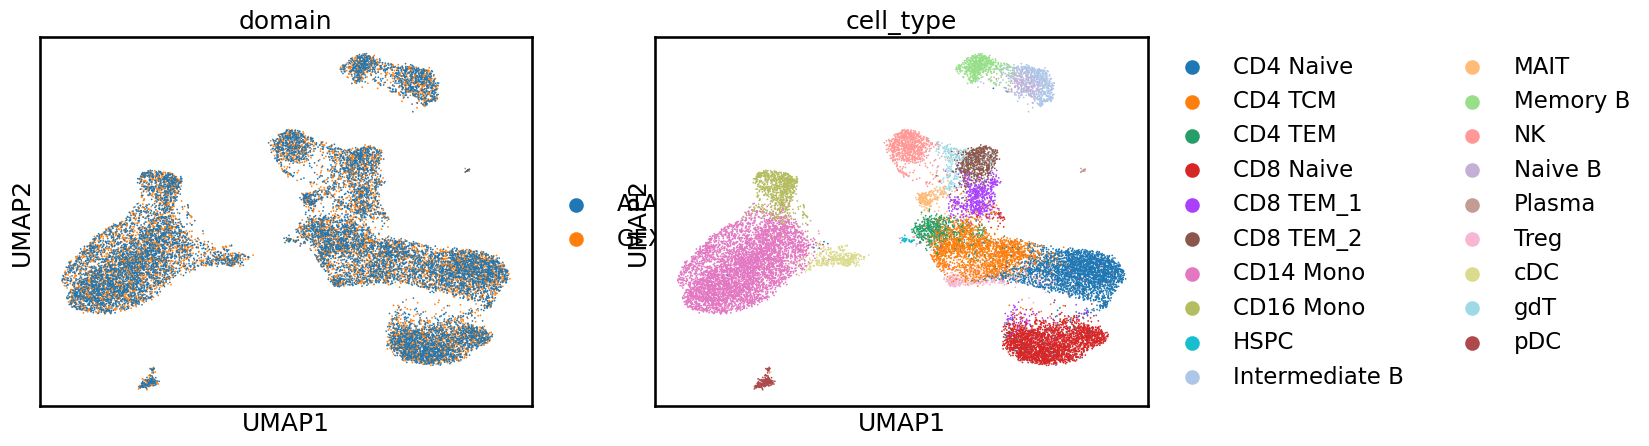

In [12]:
# Plot UMAP
sc.pl.umap(combined, color = ["domain", "cell_type"])